# Opponent

In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import torch

torch.cuda.is_available()

True

In [3]:
import torch

class Policy(torch.nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        
        self.h1 = torch.nn.Sequential(
                torch.nn.Linear(in_features=142, out_features=300, bias=True),
                torch.nn.Tanh()
            )
        self.h2 = torch.nn.Sequential(
            torch.nn.Linear(in_features=300, out_features=300, bias=True),
            torch.nn.Tanh()
        )
        
        self.logits =  torch.nn.Sequential(
            torch.nn.Linear(in_features=300, out_features=4, bias=True),
        )
        
    def forward(self, x):
        x = self.h1(x)
        x = self.h2(x)
        return self.logits(x)

# policy_path = '../checkpoints/race_v2.0.4.pt'
# exported_policy = Policy()
# exported_policy.h1.load_state_dict(torch.load(policy_path)['h1'])
# exported_policy.h2.load_state_dict(torch.load(policy_path)['h2'])
# exported_policy.logits.load_state_dict(torch.load(policy_path)['logits'])
# exported_policy.eval()

In [4]:
class PolicyWrapper:
    def __init__(self, load_path='models/'):
        self.device = torch.device('cuda')
        self.policy = Policy()
        self.policy.to(self.device)
        self.policy.h1.load_state_dict(torch.load(load_path)['h1'])
        self.policy.h2.load_state_dict(torch.load(load_path)['h2'])
        self.policy.logits.load_state_dict(torch.load(load_path)['logits'])
        self.policy.eval()
        
    def get_action(self, observation):
        obs_t = torch.tensor(observation, dtype=torch.float32).to(self.device)
        acts = self.policy(obs_t).detach().cpu().numpy()
        v, th = np.clip(acts[0], -1, 1), np.clip(acts[1], -1, 1)
        #v, th = acts[0], acts[1]
        return v, th
    
op_policy = PolicyWrapper('../checkpoints/race_v2.0.4.pt')


# environment

In [5]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from scipy.spatial.distance import cdist


class F110RaceEnv(gym.Env):
    def __init__(self, env_config,
                 test_map_name=None,
                 scan_range=10.0,
                 max_v=20.0,
                 n_cps = 110,
                 cp_reward = 0.1,
                 min_cp_dist=3.0,
                 maps_path='../maps',
                 models_path='../checkpoints',
                 train_map_name='Oschersleben',
                 padding_punish=0.0,
                 safe_padding=0.4,
                 laps = 1.0,
                 min_deg=90,
                 max_deg=270,
                 begin_pos=[
                     [0.9966514, -0.9306893, 2.79787],
                    [0.0702245, 0.3002981, 2.79787],
                    ],
                 op=op_policy
                ):
        
        self.laps = laps
        self.maps_path = maps_path
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(182,), dtype=np.float32)
        self.max_v = max_v
        self.test_map_name = test_map_name
        self.min_cp_dist = min_cp_dist
        self.n_cps = n_cps
        self.cp_reward = cp_reward
        self.scan_range = scan_range
        self.safe_padding = safe_padding
        self.map_path = None
        self.train_map_name = train_map_name
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)
        self.cum_r = 0
        self.prev_vel = [4.0] * 100
        self.padding_punish = padding_punish
        self.op_policy = op_policy
        self.total_padding_punish = 0
        self.min_deg = min_deg
        self.max_deg = max_deg
        self.begin_pos = begin_pos
        self.prev_cp_t = 0
        self.ego_forward = False
        
        self.ego_passed_cps = 0
        self.op_passed_cps = 0
        self.op_next_cp_idx = 0
        self.op_prev_state = None
        self.cp_prev_vel = []
        self.took_over = False
    

    def load_train_setup(self):
        
        map_path = f"{self.maps_path}/{self.train_map_name}"
        with open(f'{self.maps_path}/{self.train_map_name}-wp.np', 'rb') as f:
            wps = np.load(f)
            
        return map_path, wps
    
    def load_test_setup(self):
        map_path = f"{self.maps_path}/{self.test_map_name}"
        with open(f'{self.maps_path}/{self.train_map_name}-wp.np', 'rb') as f:
            wps = np.load(f)
            
        return map_path, wps

    def build_checkpoints(self, wps, cp_dist):
        
        start = np.random.randint(0, len(wps)-1)
        checkpoints = []
        
        i = 0
        while i < len(wps):
            if i % cp_dist == 0:
                checkpoints.append(wps[(start+i)%len(wps)])
            i += 1
        return checkpoints
    
    def reset(self):
        self.ego_passed_cps = 0
        self.op_passed_cps = 0
        self.took_over = False
        
        self.prev_vel = [3.0] * 100
        self.total_padding_punish = 0
        self.cum_r = 0
        self.prev_cp_t = 0
        self.op_prev_state = None
        self.op_base_vel = np.random.uniform(low=7.0, high=10.0)
        
        if self.test_map_name is not None:
            map_path, wps = self.load_test_setup()
        else:
            map_path, wps = self.load_train_setup()
        
#         print(map_path, len(wps))
        self.map_path = map_path
        self.env = gym.make('f110_gym:f110-v0', map=map_path, map_ext='.png', num_agents=2)
        
        cp_dist = len(wps)//self.n_cps
        
        self.checkpoints = self.build_checkpoints(wps, cp_dist)
        
        if self.test_map_name is not None:
            dists = cdist([self.begin_pos[0][:2]], np.array(self.checkpoints)[:,:2])
            start_idx = np.argmin(dists)
            self.ego_abs_idx = start_idx
            self.op_abs_idx = start_idx
            
            self.next_cp_idx = (start_idx + 2)%len(self.checkpoints)
            self.op_next_cp_idx = self.next_cp_idx

            obs, step_reward, done, info = self.env.reset(
                np.array(
                    self.begin_pos
                )
            )
        else:  
            start_idx = np.random.randint(0, len(self.checkpoints))
            start_point = self.checkpoints[start_idx]
            self.ego_abs_idx = start_idx
            shift = np.random.choice([-4, 4], p=[0.25, 0.75])
            self.ego_forward = True if shift < 0 else False
            self.op_abs_idx = start_idx+shift
            op_start_idx = (start_idx + shift)%len(self.checkpoints)
            op_start_point = self.checkpoints[op_start_idx]
            
            self.next_cp_idx = (start_idx + 2)%len(self.checkpoints)
            self.op_next_cp_idx = (op_start_idx + 2)%len(self.checkpoints)

            obs, step_reward, done, info = self.env.reset(
                np.array([
                   start_point,    
                   op_start_point
                ])
            )
        
            
        self.t = 0
        self.op_prev_state = self.to_vector_state_op(obs)
        
        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        ranges = obs['scans'][0]
        ranges = ranges[int((self.min_deg/360)*len(ranges)):int((self.max_deg/360)*len(ranges))]
        scanner = np.clip(ranges, 0, self.scan_range)
        
        buck = 3
        size = len(scanner)//buck
        agg_scanner = np.zeros(size,)
        for i in range(size):
            agg_scanner[i] = np.min(scanner[i*buck: i*buck+buck])
        
        agg_scanner /= self.scan_range
        state = np.concatenate([
            agg_scanner,
            np.array(obs['linear_vels_x'][:1])/self.max_v,
            np.array(obs['ang_vels_z'][:1])/self.max_v,
        ])
        
        return state
    
        
    def to_vector_state_op(self, obs):
        ranges = obs['scans'][1]
        ranges = ranges[int((110/360)*len(ranges)):int((250/360)*len(ranges))]
        scanner = np.clip(ranges, 0, self.scan_range)
        
        buck = 3
        size = len(scanner)//buck
        agg_scanner = np.zeros(size,)
        for i in range(size):
            agg_scanner[i] = np.min(scanner[i*buck: i*buck+buck])
        
        agg_scanner /= self.scan_range
        state = np.concatenate([
            agg_scanner,
            np.array(obs['linear_vels_x'][1:])/15.,
            np.array(obs['ang_vels_z'][1:])/15.,
        ])
        
        return state
    
    def checkpoint(self, position, op_position, t):
        return_cp_idx = (self.next_cp_idx - 10)%len(self.checkpoints)
        return_dist = np.linalg.norm(position - self.checkpoints[return_cp_idx][:2])
        dist = np.linalg.norm(position - self.checkpoints[self.next_cp_idx][:2])
        opdist = np.linalg.norm(op_position - self.checkpoints[self.op_next_cp_idx ][:2])
        
        if opdist < self.min_cp_dist:
            self.op_passed_cps += 1
            self.op_abs_idx += 1
            self.op_next_cp_idx = (self.op_next_cp_idx + 1)%len(self.checkpoints)
        
        reward = 0
        if dist < self.min_cp_dist:
            self.ego_passed_cps += 1
            self.ego_abs_idx += 1
#             reward = self.cp_reward
            time_diff = t - self.prev_cp_t
            reward = max(self.cp_reward + (0.4 - time_diff)*0.5, self.cp_reward)
            self.prev_cp_t = t
            self.next_cp_idx = (self.next_cp_idx + 1)%len(self.checkpoints)
        
        elif return_dist < 3.0:
            reward = -1
        return reward
        
        
    def step(self, action):
        reward = 0

        act_v = action[0]*(self.max_v/2)+(self.max_v/2)
        self.prev_vel.insert(0, act_v)
        self.prev_vel.pop()
        th = action[1]*np.pi/6
        
        op_v, op_th = self.op_policy.get_action(self.op_prev_state)
        op_th *= np.pi/6
        op_v = op_v*(self.op_base_vel/2)+(self.op_base_vel/2)
        
        act = np.array([
            [th, act_v],
            [op_th, op_v]
        ])

        obs, step_reward, done, info = self.env.step(act)
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]
        
        self.op_prev_state = self.to_vector_state_op(obs)
        next_state = self.to_vector_state(obs)
        position = np.array([pose_x, pose_y])
        op_position = np.array([obs['poses_x'][1], obs['poses_y'][1]])
    
        finish_time = 100
        if obs['collisions'][0] == 1.0:
            reward = -1
            done = True
            return next_state, reward, done, {'finish_time': finish_time}
            
        if self.op_passed_cps > self.ego_passed_cps + 10:
            reward = -1
            done = True
            return next_state, reward, done, {'finish_time': finish_time}
        
        
        if (self.ego_abs_idx > self.op_abs_idx
            and not self.ego_forward
            and not self.took_over):
            print("Agent took over!")
            reward = +1
            self.took_over = True
        
#         if self.ego_abs_idx > self.op_abs_idx + 20 and self.test_map_name is None:
#             if not self.ego_forward:
#                 print("AGENT RAN AWAY!")
#             done = True
    
        cp_reward = self.checkpoint(position, op_position, obs['lap_times'][0])
        reward += cp_reward
        self.t += 1
        
        if obs['lap_counts'][0] == self.laps:
            t = obs['lap_times'][0]  
            finish_time = t
            print(f"agent on {self.map_path} got reward {self.cum_r} in {t}. Finish reward: {reward}. Padding punish: {self.total_padding_punish}")
            print(f"was ahead:{self.ego_forward} and take over:{self.took_over}")
            done = True
        elif cp_reward == -1:
            t = obs['lap_times'][0]
            print(f"agent on {self.map_path} got reward {self.cum_r} in {t}. RETURNED")
            done = True
        elif np.max(self.prev_vel)<3.0:
            t = obs['lap_times'][0]
            print(f"agent on {self.map_path} got reward {self.cum_r} in {t}. STOPPED")
            reward = -1
            done = True
        
        if done and self.test_map_name is not None:
            print('lap:', obs['lap_times'])
        
        if np.min(obs['scans'][0]) < self.safe_padding:
            reward += self.padding_punish
            self.total_padding_punish += self.padding_punish
        
        self.cum_r += reward
        return next_state, reward, done, {'pos': position, 'finish_time': finish_time,
                                           'padding': self.total_padding_punish}
    
    def render(self):
        self.env.render()

e = F110RaceEnv({})
e.reset().shape

(182,)

# training

In [ ]:
%%time

import ray
from ray.rllib.agents import ppo
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

ray.shutdown()
ray.init()



# with half cheeta configs

hc_configs = {
    'framework': 'torch',
    'num_workers': 15,
    'gamma': 0.99,
    'num_gpus': 1.0,
    'kl_coeff': 1.0,
    'clip_param': 0.2,
    'model': {
        'fcnet_hiddens': [300, 300],
    },
#     'num_gpus_per_worker': 1/15,
    'num_envs_per_worker': 1,
    'train_batch_size': 100000,
    'sgd_minibatch_size': 4096,
    'batch_mode': 'truncate_episodes',
    'lr': .0001,
#     'horizon': 8000
}


trainer = ppo.PPOTrainer(env=F110RaceEnv, config=hc_configs)
#print("FINE TUNING")
trainer.restore('../checkpoints/race_v2.3.5/checkpoint_000042/checkpoint-42')

print(trainer.config)
rewards = []
eval_rewards = []
best_time = 1000
models_path = '../checkpoints'

import pickle

def evaluate(model, env, k):
    avg_time = []
    
    for _ in range(k):
        done = False
        obs = env.reset()

        r = 0
        while not done:
            action = model.compute_single_action(obs, explore=False)
            obs, reward, done, info = env.step(action)
            r += reward

        avg_time.append(info['finish_time'])
        
    return np.mean(avg_time)


sim_name = 'race_v2.3.7'
best_reward = -100
eval_env = F110RaceEnv({}, test_map_name='Oschersleben', laps=1)

for i in range(300):
    result = trainer.train()
    episode_r = result['episode_reward_mean']
    print(f"episode: {i} reward:{episode_r}")
    rewards.append(episode_r)
    with open(f'{models_path}/{sim_name}_r', 'wb') as f:
        pickle.dump(rewards, f)
        
    if i%5 == 0:
        eval_time = evaluate(trainer, eval_env, k=3)
        print(f"evaluation time: {eval_time}") 
        eval_rewards.append(eval_time)
        with open(f'{models_path}/{sim_name}_er', 'wb') as f:
            pickle.dump(eval_rewards, f)
        if episode_r > best_reward:
            best_reward = episode_r
            cp = trainer.save(f"{models_path}/{sim_name}")
            print("checkpoint saved at", cp)


In [7]:
#!rm -rf ../checkpoints/race_v2.1.1

## evaluation

In [6]:
import ray
from ray.rllib.agents import ppo
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

DEFAULT_CONFIG['framework'] = 'torch'
DEFAULT_CONFIG['num_workers'] = 0
DEFAULT_CONFIG['num_gpus'] = 1
DEFAULT_CONFIG['model']['fcnet_hiddens'] = [300, 300]
DEFAULT_CONFIG["evaluation_num_workers"] = 0
DEFAULT_CONFIG["evaluation_config"]["render_env"] = False
DEFAULT_CONFIG["evaluation_config"]["explore"] = False
DEFAULT_CONFIG['explore'] = False

trainer = ppo.PPOTrainer(env=F110RaceEnv, config=DEFAULT_CONFIG)
trainer.restore('../checkpoints/race_v2.3.7/checkpoint_000123/checkpoint-123')



2022-05-11 23:25:01,737	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
Install gputil for GPU system monitoring.
2022-05-11 23:25:09,174	INFO trainable.py:472 -- Restored on 10.64.91.46 from checkpoint: ../checkpoints/race_v2.3.7/checkpoint_000123/checkpoint-123
2022-05-11 23:25:09,175	INFO trainable.py:480 -- Current state after restoring: {'_iteration': 123, '_timesteps_total': 24597540, '_time_total': 10058.537306547165, '_episodes_total': 21461}


In [9]:
done = False
env = F110RaceEnv({}, test_map_name='Oschersleben', laps=1)
obs = env.reset()
poses = []
hist = []

r = 0
i = 0
while not done:
    i += 1
    action = trainer.compute_single_action(obs, explore=False)
    obs, reward, done, info = env.step(action)
    if 'pos' in info:
        pos = info['pos'] 
        hist.append([obs[-2], reward, done, pos])
    
    if i % 100 == 0 and len(pos)>0:
        poses.append(pos)
    r += reward
    
print(f'reward:{r}')
env.close()

# hist

reward:13.64999999999934


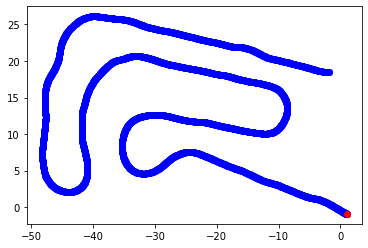

In [8]:
import matplotlib.pyplot as plt

wps = np.array([i[-1] for i in hist])

plt.scatter(wps[:,0], wps[:,1], c='b')
plt.scatter(wps[0,0], wps[0,1], c='r')



## Exporting models

In [5]:
import torch

policy_model = trainer.get_policy().model
policy_model_hiddens = policy_model._hidden_layers
policy_model_logits = policy_model._logits
policy_model_hiddens

NameError: name 'trainer' is not defined

In [4]:
policy_path = '../checkpoints/race_v2.0.4.pt'
torch.save({
    'h1': policy_model_hiddens[0]._model.state_dict(),
    'h2': policy_model_hiddens[1]._model.state_dict(),
    'logits': policy_model_logits._model.state_dict()
}, policy_path)

NameError: name 'policy_model_hiddens' is not defined

In [ ]:
class Policy(torch.nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        
        self.h1 = torch.nn.Sequential(
                torch.nn.Linear(in_features=182, out_features=300, bias=True),
                torch.nn.Tanh()
            )
        self.h2 = torch.nn.Sequential(
            torch.nn.Linear(in_features=300, out_features=300, bias=True),
            torch.nn.Tanh()
        )
        
        self.logits =  torch.nn.Sequential(
            torch.nn.Linear(in_features=300, out_features=4, bias=True),
        )
        
    def forward(self, x):
        x = self.h1(x)
        x = self.h2(x)
        return self.logits(x)

exported_policy = Policy()
exported_policy.h1.load_state_dict(torch.load(policy_path)['h1'])
exported_policy.h2.load_state_dict(torch.load(policy_path)['h2'])
exported_policy.logits.load_state_dict(torch.load(policy_path)['logits'])
exported_policy.eval()

In [ ]:
done = False
env = F110RaceEnv({}, test_map_name='Oschersleben1')
obs = env.reset()
poses = []
hist = []

r = 0
i = 0
while not done:
    i += 1
    obs_t = torch.tensor(obs, dtype=torch.float32)
    output = exported_policy(obs_t).detach().numpy()
    v = output[0]
    th = output[1]
#     v = np.clip(v, -1, 1)
#     th = np.clip(th, -1, 1)
    obs, reward, done, info = env.step([v, th])
#     print(obs[-2:])
    if 'pos' in info:
        pos = info['pos'] 
        hist.append([obs[-2], reward, done, pos])
    
    if i % 100 == 0 and len(pos)>0:
        poses.append(pos)
    r += reward
    env.render()
print(f'reward:{r}')
env.close()

# hist

## Reward plots

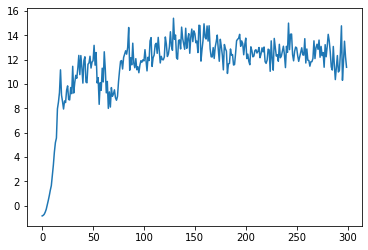

In [7]:
import matplotlib.pyplot as plt
import pickle 

with open('../checkpoints/race_v2.4.0_r', 'rb') as f:
    rs = pickle.load(f)
    
plt.plot(rs)

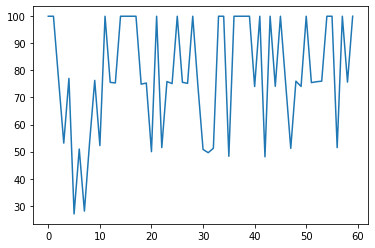

In [8]:
import matplotlib.pyplot as plt
import pickle 

with open('../checkpoints/race_v2.4.0_er', 'rb') as f:
    rs = pickle.load(f)
    
plt.plot(rs)

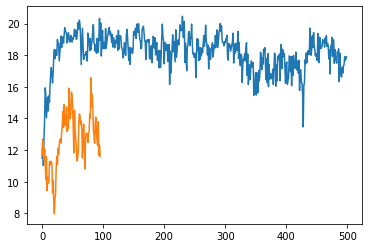

In [10]:
import matplotlib.pyplot as plt
import pickle 

with open('../checkpoints/race_v2.3.0_r', 'rb') as f:
    rs = pickle.load(f)
with open('../checkpoints/race_v2.3.7_r', 'rb') as f:
    rs2 = pickle.load(f) 
    
plt.plot(rs)
plt.plot(rs2)

In [14]:
import matplotlib.pyplot as plt
import pickle 

with open('../checkpoints/race_v2.4.4_r', 'rb') as f:
    rs = pickle.load(f)
    
plt.plot(rs)


FileNotFoundError: [Errno 2] No such file or directory: '../checkpoints/race_v2.4.4_r'

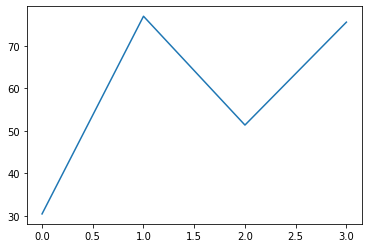

In [10]:
import matplotlib.pyplot as plt
import pickle 

with open('../checkpoints/race_v2.4.1_er', 'rb') as f:
    rs = pickle.load(f)
    
plt.plot(rs)
